In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma 
from langchain_openai import OpenAIEmbeddings 

embedding_function = OpenAIEmbeddings(model = 'text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name='income_tax_collection',
    persist_directory='./income_tax_collection'
)

retriver = vector_store.as_retriever(search_kwargs={'k': 3})

In [3]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document 
from langgraph.graph import StateGraph 

class AgentState(TypedDict): 
    query : str 
    context : List[Document]
    answer : str 

graph_builder = StateGraph(AgentState)

In [4]:
def retrive(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriver.invoke(query)
    return {'context': docs}

In [5]:
from langchain_openai import ChatOpenAI 
llm = ChatOpenAI(model='gpt-4o')

In [6]:
from langchain import hub 

generate_prompt = hub.pull("rlm/rag-prompt")

generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100) 

def generate(state: AgentState) -> AgentState: 
    context = state['context']
    query = state['query']

    rag_chain = generate_prompt | generate_llm

    response = rag_chain.invoke({"question": query, 'context': context}) 

    return {'answer': response.content}

/Users/robert/Desktop/langGrahpPrac/.venv/lib/python3.13/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [7]:
from langchain import hub
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    """
    주어진 state를 기반으로 문서의 관련성을 판단합니다.

    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.

    Returns:
        Literal['relevant', 'irrelevant']: 문서가 관련성이 높으면 'relevant', 그렇지 않으면 'irrelevant'를 반환합니다.
    """
    query = state['query']
    context = state['context']

    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})

    if response['Score'] == 1:
        # 2.3장과 다르게 `relevant`와 `irrelevant`를 반환합니다
        # node를 직접 지정하는 것보다 실제 판단 결과를 리턴하면서 해당 node의 재사용성을 높일 수 있습니다.
        return 'relevant'
    
    return 'irrelevant'

/Users/robert/Desktop/langGrahpPrac/.venv/lib/python3.13/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요 
사전: {dictionary}                                           
질문: {{query}}
""")

def rewrite(state: AgentState) -> AgentState:
    """
    사용자의 질문을 사전을 참고하여 변경합니다.

    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.

    Returns:
        AgentState: 변경된 질문을 포함하는 state를 반환합니다.
    """
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query': query})
    return {'query': response}


In [9]:
from langchain import hub 

# hallucination_prompt = hub.pull("langchain-ai/rag-answer-hallucination")

hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}
student_answer: {student_answer}
""")

hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)

def check_halluciantion(state: AgentState) -> Literal['hallucinated', 'not hallucinated'] : 
# def check_halluciantion(state: AgentState) : 
    answer = state['answer']
    context = state['context'] 

    context = [doc.page_content for doc in context]

    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    # hallucination_chain = hallucination_prompt | hallucination_llm 
    
    response = hallucination_chain.invoke({
        'student_answer': answer, 
        'documents': context
    })

    return response 
    

In [10]:
query = "연봉 6천만원인 거주자의 소득세는?"
retrive_context = {
    'query' : query 
}

context = retrive(retrive_context)['context']

generate_state = {
    'query' : query,
    'context': context 
}

answer = generate(generate_state)

print(answer)

hallucination_state = {
    'answer' : answer, 
    'context' : context 
}

check_halluciantion(hallucination_state)


{'answer': '연봉 6천만 원인 거주자의 소득세는 624만 원 + (6천만 원을 초과하는 금액의 24퍼센트)입니다. 따라서, 초과 금액인 1천만 원에 대해 24%를 적용하여 계산하면, 추가적인 소득세는 240만 원이 됩니다. 총 소득세는 864만 원입니다.'}


'not hallucinated'

In [11]:
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state: AgentState) -> Literal['helpful', 'unhelpful']: 
    query = state['query']
    answer = state['answer'] 

    helpfulness_chain = helpfulness_prompt | llm 

    response = helpfulness_chain.invoke({
        'question': query, 
        'student_answer': answer
    })

    if response['Score'] == 1:
        return 'helpful'

    return 'unhelpful'

def check_helpfulness(state: AgentState) -> AgentState: 
    return state 
    

/Users/robert/Desktop/langGrahpPrac/.venv/lib/python3.13/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [12]:
query = "연봉 6천만원인 거주자의 소득세는?"
retrive_context = {
    'query' : query 
}

context = retrive(retrive_context)['context']

generate_state = {
    'query' : query,
    'context': context 
}

answer = generate(generate_state)

helpfulness_state = {
    'query': query,
    'answer': answer
}

check_helpfulness_grader(helpfulness_state)

'helpful'

In [13]:
graph_builder.add_node('retrieve', retrive)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance, 
    {
        'relevant': 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_halluciantion,
    {
        'not hallucinated': 'check_helpfulness',
        'hallucinated': 'generate'
    }
)

graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful': END,
        'unhelpful': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'retrieve')

In [15]:
graph = graph_builder.compile()

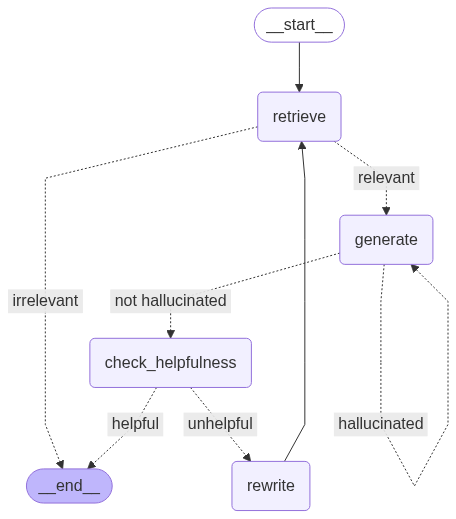

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
initial_state = {'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='| 1,400만원 초과     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)                    |\n| 5,000만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트)                  |\n| 8,800만원 이하     | 1,536만원 + (8,800만원을 초과하는 금액의 35퍼센트)                |\n| 1억5천만원 이하    | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)                |\n| 3억원 이하        | 9,406만원 + (3억원을 초과하는 금액의 40퍼센트)                    |\n| 5억원 이하        | 1억7,406만원 + (5억원을 초과하는 금액의 42퍼센트)                 |\n| 10억원 이하       | 3억3,406만원 + (10억원을 초과하는 금액의 45퍼센트)                |\n법제처 35 국가법령정보센터\n소득세법\n② 거주자의 퇴직소득에 대한 소득세는 다음 각 호의 순서에 따라 계산한 금액(이하 "퇴직소득 산출세액"이라 한다)으로 한다. <개정 2013. 1. 1, 2014. 12. 23.>\n   1. 해당 과세기간의 퇴직소득과세표준에 제11항의 세율을 적용하여 계산한 금액\n   2. 제1호의 금액을 12로 나눈 금액에 근속연수를 곱한 금액\n   3. 삭제 <2014. 12. 23.>\n   [전문개정 2009. 12. 31.]\n제2관 세액공제 <개정 2009. 12. 31.>\n제56조(배당세액공제) ① 거주자의 종합소득금액에 제17조제3항 각 호 외의 부분 단서가 적용되는 배당소득금액이 합산되어 있는